# Embedding Analysis

## Authorise

In [2]:
import json
import os
from urllib import error, parse, request


BASE_URL = os.getenv("LATER_SERVER_URL", "http://localhost:8000")


def _build_url(path):
    base = BASE_URL.rstrip("/") + "/"
    return parse.urljoin(base, path.lstrip("/"))


def _json_request(method, path, payload=None, token=None):
    """Perform an HTTP request and decode a JSON response when possible."""
    url = _build_url(path)
    data = None
    headers = {"Accept": "application/json"}

    if payload is not None:
        data = json.dumps(payload).encode("utf-8")
        headers["Content-Type"] = "application/json"

    if token:
        headers["Authorization"] = f"Bearer {token}"

    req = request.Request(url, data=data, headers=headers, method=method.upper())

    try:
        with request.urlopen(req) as resp:
            status = resp.status
            raw_body = resp.read()
            content_type = resp.headers.get("Content-Type", "")
    except error.HTTPError as exc:
        status = exc.code
        raw_body = exc.read() or b""
        content_type = exc.headers.get("Content-Type", "")
    except error.URLError as exc:  # pragma: no cover - network issues are fatal
        raise RuntimeError(f"Unable to reach server at {url}: {exc.reason}") from exc

    if not raw_body:
        body = None
    elif "application/json" in content_type.lower():
        try:
            body = json.loads(raw_body.decode("utf-8"))
        except json.JSONDecodeError:
            body = raw_body.decode("utf-8", errors="replace")
    else:
        body = raw_body.decode("utf-8", errors="replace")

    return status, body


def _login(username, password):
    return _json_request(
        "POST",
        "/auth/login",
        payload={"username": username, "password": password},
    )


def create_user(username="test_user1", password="password"):
    """Create a user through the public API, ignoring duplicates."""
    status, body = _json_request(
        "POST",
        "/user/add",
        payload={"username": username, "password": password},
    )
    if status == 201 and isinstance(body, dict):
        return body
    if status == 409:
        return None
    raise RuntimeError(f"User creation failed ({status}): {body}")


def authenticated(username="test_user1", password="password"):
    """Authenticate a user, creating it first if necessary.

    Returns the JWT token for authenticated requests.
    """
    status, body = _login(username, password)
    if status == 401:
        create_user(username, password)
        status, body = _login(username, password)

    if status != 200 or not isinstance(body, dict):
        raise RuntimeError(f"Authentication failed ({status}): {body}")

    return body["access_token"]


if __name__ == "__main__":
    # Authenticate and obtain a token
    USERNAME = "test_user1"
    PASSWORD = "password"
    TOKEN = authenticated(username=USERNAME, password=PASSWORD)


## Seed Database

In [2]:
def add_urls(urls, token):
    """Add each URL via the item API, returning per-URL results."""
    results = []

    for url in urls:
        status, body = _json_request(
            "POST",
            "/item/add",
            payload={"url": url},
            token=token,
        )
        result = {
            "url": url,
            "status": status,
            "response": body,
        }
        results.append(result)

    return results


if __name__ == "__main__":

    results = add_urls([
        "https://www.anthropic.com/engineering/building-effective-agents", # agents AI
        "https://transformer-circuits.pub/2022/toy_model/index.html", # AI
        "https://blog.langchain.com/context-engineering-for-agents/", # agents, AI
        "https://cognition.ai/blog/dont-build-multi-agents", # agents
        "https://aeon.co/essays/when-ai-summaries-replace-hyperlinks-thought-itself-is-flattened", # AI
        "https://sergeylevine.substack.com/p/language-models-in-platos-cave?utm_source=substack&utm_campaign=post_embed&utm_medium=email", # AI
        "https://arxiv.org/abs/2505.10468v4", # AI, agents
        "https://magazine.sebastianraschka.com/p/understanding-multimodal-llms?utm_source=substack&utm_medium=email", # AI, multimodal
        "https://www.theguardian.com/news/2025/sep/11/hope-fight-ecological-disaster-climate-catastrophe", # climate_change,
        "https://www.science.org/doi/10.1126/scirobotics.adv7932", # robotics, science
        "https://www.science.org/doi/10.1126/science.adx870", # climate_change
        "https://www.bbc.co.uk/sport/athletics/articles/c5yj0wyje7lo", #climate_change, sport
        "https://www.theguardian.com/sport/2025/sep/21/marlen-reusser-dominates-time-trial-at-cycling-road-world-championships", # sport, news
        "https://mistral.ai/news/codestral-25-08", #AI, news
        "https://techcrunch.com/2025/09/24/it-isnt-your-imagination-google-cloud-is-flooding-the-zone/", # AI, news
        "https://www.amazon.science/blog/simplifying-book-discovery-with-ml-powered-visual-autocomplete-suggestions?utm_source=substack&utm_medium=email", # ML
        "https://observer.co.uk/news/international/article/what-would-orwell-have-made-of-musk", # news
        "https://docs.mistral.ai", # documentation, ai
        "https://en.wikipedia.org/wiki/Mistral_AI", # mistral, ai
        "https://en.wikipedia.org/wiki/Paris", #paris
    ], TOKEN)

## Data Extraction

In [31]:
import pandas as pd
from IPython.display import display
import numpy as np


def list_items(columns, filters, token):
    """Return the items associated with the authenticated user."""
    # Build query parameters
    query_params = []
    for col in columns:
        query_params.append(f"columns={col}")
    for filt in filters:
        field, op, value = filt
        query_params.append(f"filter={field}:{op}:{value}")

    path = "/items"
    if query_params:
        path += "?" + "&".join(query_params)
    
    print(f"Request URL: {path}")
    print(f"Query params: {query_params}")

    status, body = _json_request("GET", path, token=token)
    print(f"Response status: {status}")
    if status != 200:
        print(f"Error response: {body}")
        raise RuntimeError(f"Unable to list items ({status}): {body}")
    if not isinstance(body, list):
        raise RuntimeError(f"Unexpected payload from /items: {body}")
    
    print(f"Returned {len(body)} items")
    return body
    

columns = ["id", "title", "mistral_embedding", "summary"]
filters = [("server_status", "=", "embedded")]
results = list_items(columns, filters, TOKEN)

DATA_DF = pd.DataFrame(results)
VE = np.array([np.fromstring(s.strip("[]"), sep=",") for s in DATA_DF["mistral_embedding"]]) # norm vec embeddings

display(DATA_DF)

Request URL: /items?columns=id&columns=title&columns=mistral_embedding&columns=summary&filter=server_status:=:embedded
Query params: ['columns=id', 'columns=title', 'columns=mistral_embedding', 'columns=summary', 'filter=server_status:=:embedded']
Response status: 200
Returned 17 items


,id,title,mistral_embedding,summary
0,f65800f2-a684-4157-aa41-7b4871c8dc52,Mistral AI - Wikipedia,"[-0.0070381165,0.06427002,0.026306152,0.016067...",Mistral AI is a French artificial intelligence...
1,4a419f91-d84e-435b-bb9e-49be32b7ccad,Bienvenue to Mistral AI Documentation | Mistra...,"[-0.01864624,0.048034668,0.020050049,0.0113677...",Mistral AI is a research lab that develops adv...
2,809c6b24-2742-4b94-af73-c9ce3ea2b8b0,What would Orwell have made of Musk? | The Obs...,"[-0.013000488,0.040863037,0.06933594,-0.025115...",This article from The Observer explores the ir...
3,8e69609e-cc28-4895-bab0-c5dc14892ddf,Simplifying book discovery with ML-powered vis...,"[-0.04724121,0.028823853,0.056610107,-0.011375...",Amazon Science discusses a new ML-powered visu...
4,a0e30dd4-fbf8-4613-b1d9-bf3e39488546,It isn't your imagination: Google Cloud is flo...,"[-0.02507019,0.031433105,0.04144287,-0.0020923...",The article discusses Google Cloud's strategy ...
5,9c992b55-8df7-4f42-bdb2-1d7d8d11f7a5,Announcing Codestral 25.08 and the Complete Mi...,"[-0.030380249,0.033447266,0.038604736,0.013778...",Mistral AI announces Codestral 25.08 and its c...
6,588d6030-f2f3-41b6-a386-6ee86539da31,Marlen Reusser and Remco Evenepoel take world ...,"[-0.047027588,0.046325684,0.05026245,0.0019989...",Marlen Reusser of Switzerland and Remco Evenep...
7,67688f91-a1a4-443a-9e65-6e33c81088a5,"New championships, new calendar? What next for...","[-0.024963379,0.06213379,0.05529785,-0.0194854...",World Athletics president Sebastian Coe discus...
8,16bd1d91-ebbd-4648-9206-d9ce6cc708ab,‘We’ve done it before’: how not to lose hope i...,"[-0.027999878,0.04660034,0.060699463,-0.006366...",The article discusses historical transitions f...
9,eb27e5c8-446a-43b9-ade5-85b4bdbd24f9,Understanding Multimodal LLMs,"[-0.024978638,0.060333252,0.029968262,-0.00159...",The article provides an in-depth introduction ...


In [33]:
# Normalise
from sklearn.preprocessing import normalize
print(np.mean(np.linalg.norm(VE, axis=1, keepdims=True)))
# VE /= np.linalg.norm(VE, axis=1, keepdims=True)
VE = normalize(VE, norm='l2') # more robust
print(np.mean(np.linalg.norm(VE, axis=1, keepdims=True)))

# Dimensional Reduction (PCA)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(VE)
pca = PCA(n_components=10)
VE_red = pca.fit_transform(VE)


1.0
1.0


## Clustering

In [5]:
"""
k-means


"""

from sklearn.cluster import KMeans
from collections import defaultdict

def outlier_singletons(cluster_labels):
    """
    Set clusters with only one item as outliers (label -1).
    Args:
        cluster_labels (array-like): Cluster labels for each item.
    Returns:
        np.ndarray: Modified cluster labels with singletons set to -1.
    """
    labels = np.asarray(cluster_labels).copy()
    unique, counts = np.unique(labels, return_counts=True)
    singleton_clusters = set(unique[counts == 1])
    for idx, label in enumerate(labels):
        if label in singleton_clusters:
            labels[idx] = -1
    return labels

def kmeans_clustering(VE, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(VE)
    clusters = outlier_singletons(clusters)
    return clusters

km_clusters = kmeans_clustering(VE, k=6)

print("km clusters: ", km_clusters)

def print_titles_by_cluster(titles, cluster_labels):
    """
    Print article titles grouped by cluster.

    Args:
        titles (pd.Series or list): Titles to group.
        cluster_labels (list or np.ndarray): Cluster label for each title.
    """

    cluster_to_titles = defaultdict(list)
    for title, cluster_id in zip(titles, cluster_labels):
        cluster_to_titles[cluster_id].append(title)

    for cluster_id, titles_in_cluster in sorted(cluster_to_titles.items()):
        print(f"Cluster {cluster_id}:")
        for title in titles_in_cluster:
            print(f"  - {title}")
        print()

print_titles_by_cluster(DATA_DF["title"], km_clusters)

km clusters:  [ 2  2  4 -1  1  2  0  0  4  3  1  3  4  1  1  3  1]
Cluster -1:
  - Simplifying book discovery with ML-powered visual autocomplete suggestions

Cluster 0:
  - Marlen Reusser and Remco Evenepoel take world time trial titles in Rwanda
  - New championships, new calendar? What next for athletics after Tokyo

Cluster 1:
  - It isn't your imagination: Google Cloud is flooding the zone | TechCrunch
  - AI Agents vs. Agentic AI: A Conceptual Taxonomy, Applications and Challenges
  - Cognition | Don’t Build Multi-Agents
  - Context Engineering
  - Building Effective AI Agents

Cluster 2:
  - Mistral AI - Wikipedia
  - Bienvenue to Mistral AI Documentation | Mistral AI
  - Announcing Codestral 25.08 and the Complete Mistral Coding Stack for Enterprise | Mistral AI

Cluster 3:
  - Understanding Multimodal LLMs
  - Language Models in Plato's Cave
  - Toy Models of Superposition

Cluster 4:
  - What would Orwell have made of Musk? | The Observer
  - ‘We’ve done it before’: how not t

In [6]:
"""
HCA (agglomerative)

- choose clusters by distance threshold or number of clusters
- O(n^3) time complexity, O(n^2) space complexity - not great for large datasets
"""

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.cluster import AgglomerativeClustering


def hca_clustering(VE, d_threshold=None, n_clusters=None):
    # === SCIPY ===
    # cos_sim = VE @ VE.T  # (n, n) - if large, make more efficient to avoid redundant compuatation
    # cos_dist = 1 - cos_sim  
    # cos_dist_vec = squareform(cos_dist, checks=False)  # 1D condensed form
    # linkage_matrix = linkage(cos_dist_vec, method='average')
    # dendrogram(linkage_matrix, labels=DATA_DF.index.tolist())
    # if n_clusters is not None:
    #     clusters = fcluster(linkage_matrix, t=n_clusters, criterion="maxclust")
    # else:
    #     clusters = fcluster(linkage_matrix, t=d_threshold, criterion="distance")
    # hca_clusters = clusters - 1  # make zero-indexed


    # === SKLEARN ===
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters, 
        distance_threshold=d_threshold,
        metric='cosine', 
        linkage='average'
    )
    hca_clusters = clustering.fit_predict(VE)
    hca_clusters = outlier_singletons(hca_clusters)
    return hca_clusters


if __name__ == "__main__":
    d_threshold = 0.25 #0.25 # distance threshold for clustering
    n_clusters = None

    d_threshold = None
    n_clusters = 6

    hca_clusters = hca_clustering(VE, d_threshold=d_threshold, n_clusters=n_clusters)
    print("hca clusters: ", hca_clusters)

    print_titles_by_cluster(DATA_DF["title"], hca_clusters)

hca clusters:  [ 5  5  0 -1 -1  5  2  2  0  1  1  1  1  1  1  1  1]
Cluster -1:
  - Simplifying book discovery with ML-powered visual autocomplete suggestions
  - It isn't your imagination: Google Cloud is flooding the zone | TechCrunch

Cluster 0:
  - What would Orwell have made of Musk? | The Observer
  - ‘We’ve done it before’: how not to lose hope in the fight against ecological disaster

Cluster 1:
  - Understanding Multimodal LLMs
  - AI Agents vs. Agentic AI: A Conceptual Taxonomy, Applications and Challenges
  - Language Models in Plato's Cave
  - When AI summaries replace hyperlinks, thought itself is flattened | Aeon Essays
  - Cognition | Don’t Build Multi-Agents
  - Context Engineering
  - Toy Models of Superposition
  - Building Effective AI Agents

Cluster 2:
  - Marlen Reusser and Remco Evenepoel take world time trial titles in Rwanda
  - New championships, new calendar? What next for athletics after Tokyo

Cluster 5:
  - Mistral AI - Wikipedia
  - Bienvenue to Mistral A

In [7]:
"""
DBSCAN

- doesn't require k.
"""
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# X: L2-normalized embeddings, shape (n, d)
def pick_eps(X, min_samples=3):
    nn = NearestNeighbors(n_neighbors=min_samples, metric="cosine").fit(X)
    dists, _ = nn.kneighbors(X)
    kth = np.sort(dists[:, -1])  # distance to kth neighbor
    # elbow ~ percentile between 70–90% for tiny n
    return float(np.percentile(kth, 80)), kth

def create_singletons(labels):
    """Turn outliers into single clusters"""
    max_cluster = max(labels) if len(labels) > 0 and max(labels) != -1 else -1
    next_cluster_id = max_cluster + 1
    
    for i, label in enumerate(labels):
        if label == -1:
            labels[i] = next_cluster_id
            next_cluster_id += 1
    
    return labels

def dbscan_clustering(VE, eps, min_samples):
    dbscan = DBSCAN(metric="cosine", eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(VE)
    # clusters = create_singletons(labels)
    clusters = labels
    return clusters


pca = PCA(n_components=10)
VE_red = pca.fit_transform(scaled_embeddings)
eps, _ = pick_eps(VE_red, min_samples=2)
print(eps)
dbscan_clusters = dbscan_clustering(VE_red, eps=eps, min_samples=2)
print(dbscan_clusters)

print_titles_by_cluster(DATA_DF["title"], dbscan_clusters)

0.76840467357303
[ 0  0 -1  0 -1  0  1  1 -1  0  2  0 -1  2  2  0  2]
Cluster -1:
  - What would Orwell have made of Musk? | The Observer
  - It isn't your imagination: Google Cloud is flooding the zone | TechCrunch
  - ‘We’ve done it before’: how not to lose hope in the fight against ecological disaster
  - When AI summaries replace hyperlinks, thought itself is flattened | Aeon Essays

Cluster 0:
  - Mistral AI - Wikipedia
  - Bienvenue to Mistral AI Documentation | Mistral AI
  - Simplifying book discovery with ML-powered visual autocomplete suggestions
  - Announcing Codestral 25.08 and the Complete Mistral Coding Stack for Enterprise | Mistral AI
  - Understanding Multimodal LLMs
  - Language Models in Plato's Cave
  - Toy Models of Superposition

Cluster 1:
  - Marlen Reusser and Remco Evenepoel take world time trial titles in Rwanda
  - New championships, new calendar? What next for athletics after Tokyo

Cluster 2:
  - AI Agents vs. Agentic AI: A Conceptual Taxonomy, Applicatio

In [8]:
import hdbscan

def hdbscan_clustering(VE, min_cluster_size, min_samples):
    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric="euclidean")  # on unit vectors, euclidean↔cosine monotone
    labels = hdb.fit_predict(VE)
    # clusters = create_singletons(labels)
    clusters = labels
    return clusters

pca = PCA(n_components=10)
VE_red = pca.fit_transform(scaled_embeddings)
hdbscan_clusters = hdbscan_clustering(VE_red, min_cluster_size=2, min_samples=2)
print(hdbscan_clusters)
print_titles_by_cluster(DATA_DF["title"], hdbscan_clusters)

[ 0  0 -1 -1 -1  0 -1 -1 -1  1 -1  1 -1  2  2  1  2]
Cluster -1:
  - What would Orwell have made of Musk? | The Observer
  - Simplifying book discovery with ML-powered visual autocomplete suggestions
  - It isn't your imagination: Google Cloud is flooding the zone | TechCrunch
  - Marlen Reusser and Remco Evenepoel take world time trial titles in Rwanda
  - New championships, new calendar? What next for athletics after Tokyo
  - ‘We’ve done it before’: how not to lose hope in the fight against ecological disaster
  - AI Agents vs. Agentic AI: A Conceptual Taxonomy, Applications and Challenges
  - When AI summaries replace hyperlinks, thought itself is flattened | Aeon Essays

Cluster 0:
  - Mistral AI - Wikipedia
  - Bienvenue to Mistral AI Documentation | Mistral AI
  - Announcing Codestral 25.08 and the Complete Mistral Coding Stack for Enterprise | Mistral AI

Cluster 1:
  - Understanding Multimodal LLMs
  - Language Models in Plato's Cave
  - Toy Models of Superposition

Cluster 2:

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
"""
Metrics

- silhouette
- Davies bouldin
"""

from sklearn.metrics import silhouette_score, davies_bouldin_score

def cluster_eval(X, labels, metric="cosine"):
    labs = np.asarray(labels)
    # keep only clusters with size >= 2
    sizes = {c: np.sum(labs == c) for c in np.unique(labs)}
    keep_mask = np.array([sizes[c] >= 2 for c in labs])
    Xc = X[keep_mask]
    lc = labs[keep_mask]

    # core metrics
    if len(np.unique(lc)) >= 2:
        sil = float(silhouette_score(Xc, lc, metric=metric))
        db  = float(davies_bouldin_score(Xc, lc))
        n_core = int(len(np.unique(lc)))
    else:
        sil, db, n_core = np.nan, np.nan, 0

    # singleton count (non-noise)
    singleton_count = int(np.sum([sizes[c] == 1 for c in labs]))

    return {"silhouette": sil, "davies_bouldin": db,
            "n_core_clusters": n_core, "singleton_count": singleton_count}

            # Evaluate all clustering results and display as DataFrame

clusterings = {
    "KMeans": km_clusters,
    "Agglomerative": hca_clusters,
    "DBSCAN": dbscan_clusters,
    "HDBSCAN": hdbscan_clusters,
}

eval_results = []
for name, labels_ in clusterings.items():
    metrics = cluster_eval(VE, labels_)
    metrics["method"] = name
    eval_results.append(metrics)

eval_df = pd.DataFrame(eval_results).set_index("method")
print(eval_df)


               silhouette  davies_bouldin  n_core_clusters  singleton_count
method                                                                     
KMeans           0.216987        1.548165                5                1
Agglomerative    0.205564        1.509004                5                0
DBSCAN           0.129870        1.831176                4                0
HDBSCAN          0.135234        1.785937                4                0


## Labelling

In [10]:
from aglib import Context, Agent
from pydantic import BaseModel
from collections import defaultdict
from pprint import pprint
import os
import json
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

system_prompt = f"""
You are a data labeler for clusters of items. 
You will be provided a list of summaries each cluster's contents and must provide a 1-2 word label of this cluster's content.
Look for broader theme where possible.
Output in the request schema, which a UNIQUE label for each cluster.
"""

class ClusterLabel(BaseModel):
    cluster_idx: int
    label: str

class LabelOutput(BaseModel):
    labels: list[ClusterLabel]

label_agent = Agent(
    name="data_labeller",
    provider="mistral",
    model="mistral-medium-latest",
    system_prompt=system_prompt,
    tools = []
)

def label_clusters(clusters, summaries):
    summary_groups = defaultdict(list)
    for cidx, summary in zip(clusters, summaries):
        if cidx == -1:
            continue  # skip outliers
        summary_groups[int(cidx)].append(summary)

    num_clusters = len(summary_groups.keys())
    
    # Convert the summary groups to a formatted string for the API
    cluster_data = []
    for cluster_id, summaries_list in summary_groups.items():
        cluster_data.append(f"Cluster {cluster_id}:")
        for i, summary in enumerate(summaries_list, 1):
            cluster_data.append(f"  {i}. {summary}")
        cluster_data.append("")  # Empty line between clusters
    
    formatted_input = "\n".join(cluster_data)
    
    ctx = Context()
    ctx.add_user_query(formatted_input)
    output = label_agent.request(ctx, response_format=LabelOutput)

    parsed_output = LabelOutput.model_validate(json.loads(output.content))
    assert len(parsed_output.labels) == num_clusters 
    return {cl.cluster_idx: cl.label for cl in parsed_output.labels}

if __name__ == "__main__":
    clusters = km_clusters
    summaries = DATA_DF["summary"]

    labels = label_clusters(clusters, summaries)
    pprint(labels)

{0: 'Sports',
 1: 'AI Development',
 2: 'Mistral AI',
 3: 'AI Research',
 4: 'Technology and Society'}


In [11]:
from collections import defaultdict

def calculate_centroid_centres(VE, clusters):
    vecs = {}
    for v, ci in zip(VE, clusters):
        vecs[ci].append(v)
    
    for ci, vs in vecs:
        vecs[ci] = np.linalg(np.sum(vs, axis=1), axis=1)
    return vecs


## Visualisation

In [12]:
# Create a function to map cluster indices to meaningful labels
import matplotlib.pyplot as plt
import numpy as np

def create_cluster_labels_and_colors(clusters, label_dict):
    """
    Create meaningful labels and colors for clusters, handling outliers.
    
    Args:
        clusters: Array of cluster indices
        label_dict: Dictionary mapping cluster index to meaningful label
    
    Returns:
        tuple: (cluster_labels, custom_palette)
    """
    # Create labels for each data point
    cluster_labels = []
    for cluster_idx in clusters:
        if cluster_idx == -1:
            cluster_labels.append("Unclassified")
        else:
            cluster_labels.append(label_dict.get(cluster_idx, f"Cluster {cluster_idx}"))
    
    # Create a custom color palette
    unique_labels = list(set(cluster_labels))
    
    # Create color palette - grey for unclassified, distinct colors for others
    colors = []
    color_map = {}
    
    if "Unclassified" in unique_labels:
        color_map["Unclassified"] = "lightgray"
        colors.append("lightgray")
        unique_labels.remove("Unclassified")
    
    # Use tab20 colors for the rest, but ensure good contrast
    import matplotlib.pyplot as plt
    tab20_colors = plt.cm.tab20.colors
    
    for i, label in enumerate(sorted(unique_labels)):
        if i < len(tab20_colors):
            color_map[label] = tab20_colors[i]
        else:
            # Fallback to default colors if we have more clusters than tab20 provides
            color_map[label] = plt.cm.Set3(i % 12)
    
    return cluster_labels, color_map

# Apply the labeling function
cluster_labels, color_map = create_cluster_labels_and_colors(clusters, labels)
print(f"Unique cluster labels: {sorted(set(cluster_labels))}")
print(f"Color mapping: {color_map}")

Unique cluster labels: ['AI Development', 'AI Research', 'Mistral AI', 'Sports', 'Technology and Society', 'Unclassified']
Color mapping: {'Unclassified': 'lightgray', 'AI Development': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'AI Research': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 'Mistral AI': (1.0, 0.4980392156862745, 0.054901960784313725), 'Sports': (1.0, 0.7333333333333333, 0.47058823529411764), 'Technology and Society': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)}


In [13]:
clusters = dbscan_clusters

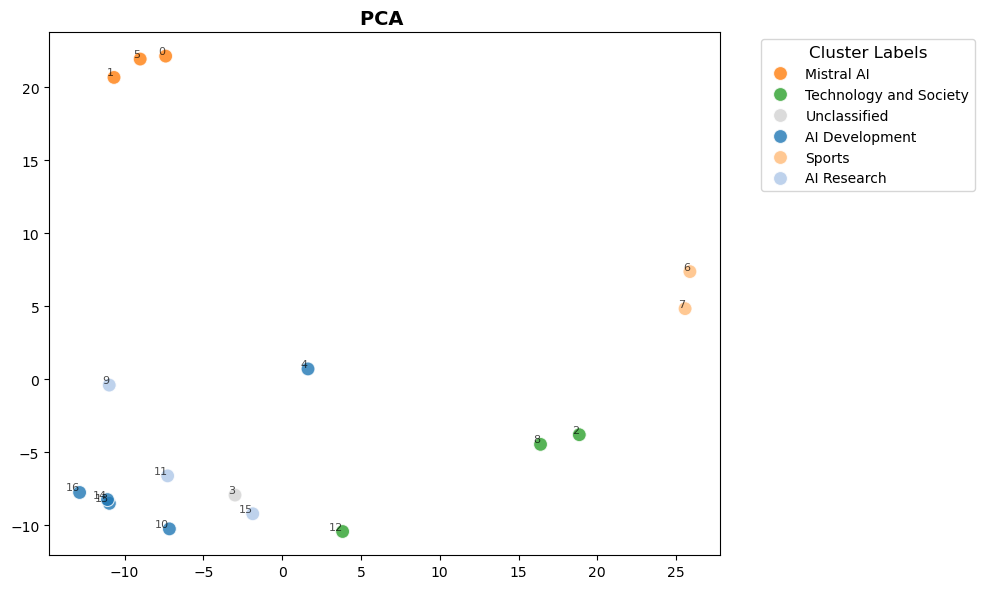

In [15]:
## PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# z-score normalization
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(VE)

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(scaled_embeddings)

# Create the plot with meaningful labels
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x=embeddings_2d[:, 0], 
    y=embeddings_2d[:, 1], 
    hue=cluster_labels,
    palette=color_map,
    s=100,  # Increase point size for better visibility
    alpha=0.8
)

# Add point index labels
for i, (x, y) in enumerate(embeddings_2d):
    ax.text(x, y, str(i), fontsize=8, ha='right', va='bottom', alpha=0.7)

plt.title('PCA ', fontsize=14, fontweight='bold')

# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster Labels', title_fontsize=12)
plt.tight_layout()
plt.show()

Using perplexity: 5


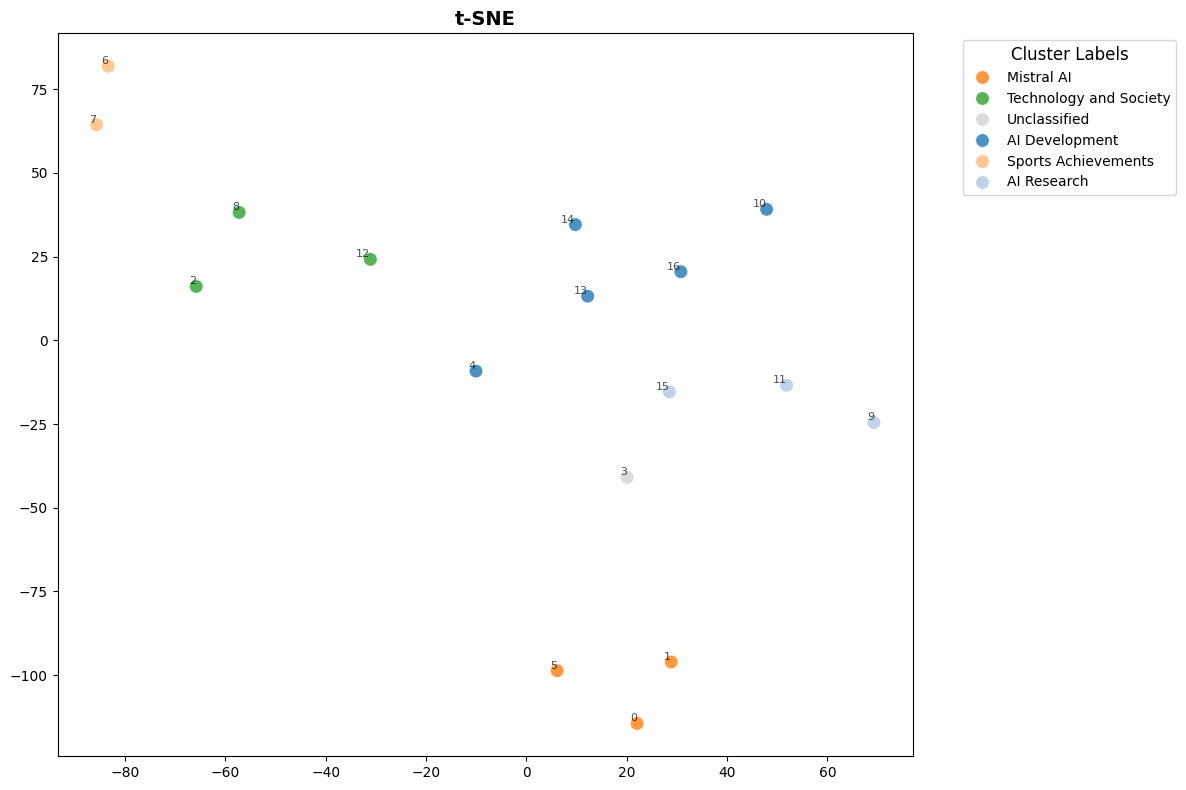

In [ ]:
"""
t-SNE

perplexity related to number of neighbours used (scale with size)
"""
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

n = VE.shape[0]
p = int(np.sqrt(n)) + 1
print(f"Using perplexity: {p}")

tsne = TSNE(n_components=2, perplexity=p, metric="cosine", random_state=42)
embeddings_2d_tsne = tsne.fit_transform(VE)

# Create the plot with meaningful labels
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    x=embeddings_2d_tsne[:, 0], 
    y=embeddings_2d_tsne[:, 1], 
    hue=cluster_labels,
    palette=color_map,
    s=100,  # Increase point size for better visibility
    alpha=0.8
)

# Add point index labels
for i, (x, y) in enumerate(embeddings_2d_tsne):
    ax.text(x, y, str(i), fontsize=8, ha='right', va='bottom', alpha=0.7)

plt.title('t-SNE', fontsize=14, fontweight='bold')


# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster Labels', title_fontsize=12)
plt.tight_layout()
plt.show()

Using n_neighbors: 8


/Users/adamdray/Projects/later-system/server/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


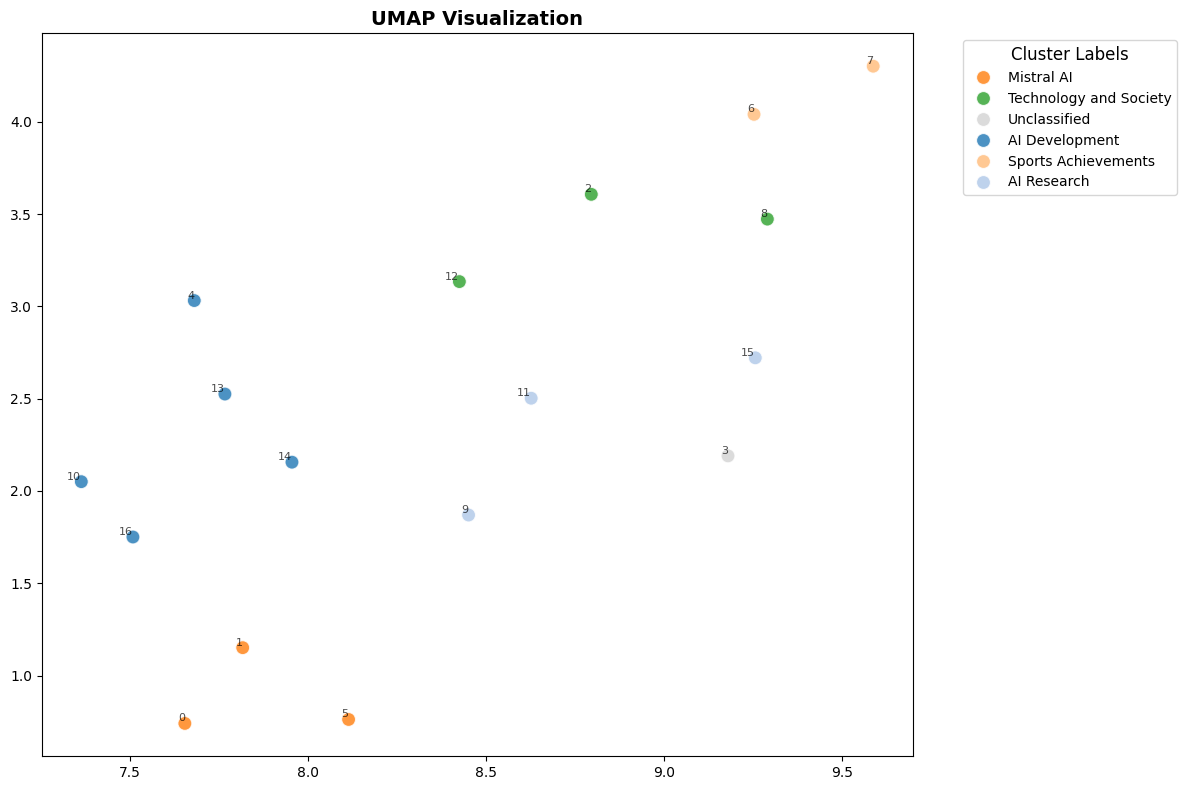

In [ ]:
"""
UMAP

n_neighbours balances local (low) vs global (high)
min_distance = smoothens features (higher)
"""

import umap
import seaborn as sns
import matplotlib.pyplot as plt

n = VE.shape[0]
nn = int(np.sqrt(n) * 2)
print(f"Using n_neighbors: {nn}")

reducer = umap.UMAP(n_components=2, n_neighbors=nn, min_dist=0.00, metric='cosine', random_state=42)
embeddings_2d_umap = reducer.fit_transform(VE)

# Create the plot with meaningful labels
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    x=embeddings_2d_umap[:, 0], 
    y=embeddings_2d_umap[:, 1], 
    hue=cluster_labels,
    palette=color_map,
    s=100,  # Increase point size for better visibility
    alpha=0.8
)

# Add point index labels
for i, (x, y) in enumerate(embeddings_2d_umap):
    ax.text(x, y, str(i), fontsize=8, ha='right', va='bottom', alpha=0.7)

plt.title('UMAP Visualization', fontsize=14, fontweight='bold')

# Improve legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster Labels', title_fontsize=12)
plt.tight_layout()
plt.show()

## Search

This section explores lexical and semantic retrieval strategies on the embedded items. The examples assume the API and database from this project are running and populated using the earlier steps in the notebook.


### 1. Lexical search with PostgreSQL `ts_vector`

We can directly leverage the `ts_embedding` column and its GIN index for ranked keyword matching.


In [17]:
import psycopg
from psycopg.rows import dict_row

POSTGRES_CONNINFO = os.getenv(
    "DATABASE_URL",
    f"postgresql://{os.getenv('POSTGRES_USER', 'later_app')}:{os.getenv('POSTGRES_PASSWORD', 'later_pass')}@{os.getenv('POSTGRES_HOST', 'localhost')}:{os.getenv('POSTGRES_PORT', '5432')}/{os.getenv('POSTGRES_DB', 'later')}"
)

def run_sql(query: str, params: dict) -> list[dict]:
    with psycopg.connect(POSTGRES_CONNINFO, row_factory=dict_row) as conn:
        with conn.cursor() as cur:
            cur.execute(query, params)
            return cur.fetchall()

LEXICAL_SQL = """
SELECT
    i.id,
    i.title,
    i.summary,
    ts_rank(i.ts_embedding, plainto_tsquery('english', %(query)s)) AS rank
FROM items AS i
JOIN users AS u ON u.id = i.user_id
WHERE u.username = %(username)s
  AND i.ts_embedding @@ plainto_tsquery('english', %(query)s)
ORDER BY rank DESC
LIMIT %(limit)s;
"""

def lexical_search(query: str, *, username: str = USERNAME, limit: int = 5) -> pd.DataFrame:
    rows = run_sql(LEXICAL_SQL, {"query": query, "username": username, "limit": limit})
    return pd.DataFrame(rows)


In [24]:
lexical_results = lexical_search("Ai Agents", limit=5)
if lexical_results.empty:
    print("No lexical matches found.")
else:
    display(lexical_results)


,id,title,summary,rank
0,ff374ee2-4ef3-4efb-a055-b902885c5c9a,AI Agents vs. Agentic AI: A Conceptual Taxonom...,This study distinguishes between AI Agents and...,0.955339
1,0066fcde-fa6d-4cd8-b215-4b6e3db2c30f,Cognition | Don’t Build Multi-Agents,The article discusses the principles of buildi...,0.237630
2,32fa89f3-509b-4550-8056-ebe0f42c00ee,Building Effective AI Agents,The article from AnthropicAI discusses the dev...,0.219654
3,9c992b55-8df7-4f42-bdb2-1d7d8d11f7a5,Announcing Codestral 25.08 and the Complete Mi...,Mistral AI announces Codestral 25.08 and its c...,0.213733
4,9c503392-9e00-4fc6-bba1-42907b8d24be,Context Engineering,The article discusses the importance of contex...,0.157185


### 2. Semantic search over full items

We embed the query text and compute similarities in three ways: direct cosine similarity against the in-memory vectors, using a `NearestNeighbors` index, and delegating to PostgreSQL's `vector` extension with its IVFFlat index.


In [ ]:
from aglib import Client
from sklearn.neighbors import NearestNeighbors

def embed_query_text(text: str) -> np.ndarray:
    client = Client.embedding(provider="mistral", model="mistral-embed")
    response = client.request(input=[text])
    vector = np.asarray(response.embeddings[0], dtype=np.float32)
    norm = np.linalg.norm(vector)
    return vector / norm

_semantic_index: NearestNeighbors | None = None

def semantic_search_raw(query_vector: np.ndarray, top_k: int = 5) -> pd.DataFrame:
    scores = VE @ query_vector
    top_idx = np.argsort(scores)[::-1][:top_k]
    result = DATA_DF.iloc[top_idx][["id", "title", "summary"]].copy()
    result["score"] = scores[top_idx]
    return result

def semantic_search_index(query_vector: np.ndarray, top_k: int = 5) -> pd.DataFrame:
    global _semantic_index
    if _semantic_index is None:
        _semantic_index = NearestNeighbors(metric="cosine")
        _semantic_index.fit(VE)
    distances, indices = _semantic_index.kneighbors(query_vector.reshape(1, -1), n_neighbors=top_k)
    scores = 1 - distances[0]
    result = DATA_DF.iloc[indices[0]][["id", "title", "summary"]].copy()
    result["score"] = scores
    return result

SEMANTIC_SQL = """
SELECT
    i.id,
    i.title,
    i.summary,
    i.mistral_embedding <-> %(query_vec)s::vector AS distance
FROM items AS i
JOIN users AS u ON u.id = i.user_id
WHERE u.username = %(username)s
ORDER BY distance ASC
LIMIT %(limit)s;
"""

def to_pg_vector(vec: np.ndarray) -> str:
    arr = np.asarray(vec, dtype=np.float32).ravel()
    return "[" + ", \n".join(f"{v:.6f}" for v in arr) + "]"

def semantic_search_pg(query_vector: np.ndarray, top_k: int = 5, *, username: str = USERNAME) -> pd.DataFrame:
    rows = run_sql(
        SEMANTIC_SQL,
        {
            "query_vec": to_pg_vector(query_vector),
            "username": username,
            "limit": top_k,
        },
    )
    df = pd.DataFrame(rows)
    if not df.empty:
        df["score"] = 1.0 / (1.0 + df.pop("distance"))
    return df


In [30]:
query_text = "Latest advances in AI agent tooling"
query_vector = embed_query_text(query_text)

import time
from functools import wraps

def timeit(func):
    """Decorator to time the execution of a function and print the duration."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} executed in {end - start:.4f} seconds")
        return result
    return wrapper


@timeit
def run_semantic_search_raw():
    print("Raw cosine similarity (in-memory)")
    display(semantic_search_raw(query_vector, top_k=5))

@timeit
def run_semantic_search_index():
    print("Indexed search with NearestNeighbors")
    display(semantic_search_index(query_vector, top_k=5))

@timeit
def run_semantic_search_pg():
    print("PostgreSQL vector index (IVFFlat)")
    display(semantic_search_pg(query_vector, top_k=5))

run_semantic_search_raw()
run_semantic_search_index()
run_semantic_search_pg()


Raw cosine similarity (in-memory)


,id,title,summary,score
16,32fa89f3-509b-4550-8056-ebe0f42c00ee,Building Effective AI Agents,The article from AnthropicAI discusses the dev...,0.817454
13,0066fcde-fa6d-4cd8-b215-4b6e3db2c30f,Cognition | Don’t Build Multi-Agents,The article discusses the principles of buildi...,0.815415
14,9c503392-9e00-4fc6-bba1-42907b8d24be,Context Engineering,The article discusses the importance of contex...,0.792271
10,ff374ee2-4ef3-4efb-a055-b902885c5c9a,AI Agents vs. Agentic AI: A Conceptual Taxonom...,This study distinguishes between AI Agents and...,0.767152
5,9c992b55-8df7-4f42-bdb2-1d7d8d11f7a5,Announcing Codestral 25.08 and the Complete Mi...,Mistral AI announces Codestral 25.08 and its c...,0.741420


run_semantic_search_raw executed in 0.0034 seconds
Indexed search with NearestNeighbors


,id,title,summary,score
16,32fa89f3-509b-4550-8056-ebe0f42c00ee,Building Effective AI Agents,The article from AnthropicAI discusses the dev...,0.817454
13,0066fcde-fa6d-4cd8-b215-4b6e3db2c30f,Cognition | Don’t Build Multi-Agents,The article discusses the principles of buildi...,0.815415
14,9c503392-9e00-4fc6-bba1-42907b8d24be,Context Engineering,The article discusses the importance of contex...,0.792271
10,ff374ee2-4ef3-4efb-a055-b902885c5c9a,AI Agents vs. Agentic AI: A Conceptual Taxonom...,This study distinguishes between AI Agents and...,0.767152
5,9c992b55-8df7-4f42-bdb2-1d7d8d11f7a5,Announcing Codestral 25.08 and the Complete Mi...,Mistral AI announces Codestral 25.08 and its c...,0.741420


run_semantic_search_index executed in 0.0050 seconds
PostgreSQL vector index (IVFFlat)


,id,title,summary,score
0,32fa89f3-509b-4550-8056-ebe0f42c00ee,Building Effective AI Agents,The article from AnthropicAI discusses the dev...,0.623350
1,0066fcde-fa6d-4cd8-b215-4b6e3db2c30f,Cognition | Don’t Build Multi-Agents,The article discusses the principles of buildi...,0.622044
2,9c503392-9e00-4fc6-bba1-42907b8d24be,Context Engineering,The article discusses the importance of contex...,0.608064
3,ff374ee2-4ef3-4efb-a055-b902885c5c9a,AI Agents vs. Agentic AI: A Conceptual Taxonom...,This study distinguishes between AI Agents and...,0.594384
4,07d11ab4-d3d2-4109-9995-5ccc2b7cfe7c,Toy Models of Superposition,The article discusses the phenomenon of superp...,0.586631


run_semantic_search_pg executed in 0.0321 seconds


#### 2.B Chunk-aware semantic search

Chunking lets us match specific passages. We retrieve chunk embeddings, search them, and aggregate the best chunk per item to produce the final ranking.


In [21]:
CHUNK_SQL = """
SELECT
    c.id,
    c.item_id,
    c.position,
    c.content_text,
    c.mistral_embedding,
    i.title
FROM item_chunks AS c
JOIN items AS i ON i.id = c.item_id
JOIN users AS u ON u.id = i.user_id
WHERE u.username = %(username)s
ORDER BY c.item_id, c.position;
"""

chunk_rows = run_sql(CHUNK_SQL, {"username": USERNAME})
CHUNK_DF = pd.DataFrame(chunk_rows)

if CHUNK_DF.empty:
    chunk_matrix = np.zeros((0, VE.shape[1]), dtype=np.float32)
else:
    CHUNK_DF["embedding"] = CHUNK_DF["mistral_embedding"].apply(lambda v: np.asarray(v, dtype=np.float32))
    chunk_matrix = np.vstack(CHUNK_DF["embedding"].to_numpy())
    chunk_matrix = normalize(chunk_matrix, norm="l2")


ValueError: could not convert string to float: '[-0.059295654,0.041992188,0.009437561,0.019546509,0.03189087,0.0044937134,0.05569458,-0.01550293,-0.02168274,0.013534546,-0.025161743,0.051879883,-0.051208496,0.009155273,-0.03616333,0.039978027,-0.018081665,0.012413025,0.04156494,0.04244995,-0.012580872,-0.01084137,-0.045166016,-0.0006108284,0.0023174286,0.0024700165,0.002035141,-0.072753906,-0.026397705,-0.009376526,0.03527832,-0.016281128,0.008422852,-0.005672455,0.014602661,0.0027942657,-0.0024986267,-0.03842163,0.0035095215,-0.008590698,0.020889282,0.016067505,-0.015388489,-0.0023593903,-0.006793976,-0.030319214,0.0012569427,-0.0011510849,-0.0021629333,-0.01184845,-0.0066566467,0.0413208,-0.025939941,-0.0034542084,-0.048980713,0.008422852,-0.012802124,-0.015274048,-0.05166626,0.00070905685,-0.018981934,-0.016174316,0.014823914,-0.019317627,0.028747559,0.03302002,0.021118164,-0.024490356,-0.006175995,-0.04537964,0.022583008,0.023590088,-0.0028362274,0.034820557,-0.021224976,-0.025726318,-0.000238657,0.026062012,0.02470398,-0.025604248,-0.015159607,0.03817749,0.06738281,-0.014038086,-0.0413208,-0.0034122467,0.012580872,-0.006259918,0.022583008,-0.0079193115,0.018753052,0.0075263977,0.0096588135,-0.028533936,0.059753418,0.025497437,-0.0048561096,0.011291504,-0.024597168,0.051208496,0.041992188,0.017745972,0.0871582,-0.020446777,0.03302002,-0.015609741,0.009994507,0.004940033,-0.0011796951,-0.04559326,-0.09210205,-0.03010559,0.022460938,-0.039764404,-0.041992188,0.026168823,-0.0078048706,0.048309326,-0.037750244,-0.07501221,0.04425049,0.0435791,-0.035705566,-0.0012426376,-0.048980713,-0.04156494,0.00041770935,0.038848877,-0.0074691772,-0.0019664764,0.0046043396,-0.018310547,-0.02470398,-0.034362793,0.02482605,-0.020553589,0.030548096,-0.009155273,-0.019760132,-0.005924225,0.03817749,-0.022232056,-0.031219482,-0.0028362274,-0.0047721863,-0.0035934448,-0.01965332,0.016616821,-0.028076172,-0.013755798,0.0076942444,0.05279541,0.075927734,-0.004295349,0.008033752,-0.027175903,-0.03842163,-0.024154663,0.048065186,0.0021343231,-0.02078247,0.016738892,-0.011062622,0.018417358,-0.012802124,-0.028640747,-0.03414917,0.0039863586,-0.024368286,-0.022583008,0.034820557,-0.039978027,0.016845703,0.04559326,-0.032348633,0.011009216,0.021560669,0.011230469,0.046936035,0.031463623,-0.018539429,-0.037078857,0.049194336,0.029434204,-0.015945435,-0.0149383545,-0.0435791,-0.0046043396,0.011680603,0.0079193115,-0.023361206,-0.025939941,-0.026062012,0.020217896,0.00032639503,0.037078857,0.012077332,-0.035705566,0.045837402,0.0005440712,0.043121338,0.03010559,-0.012184143,0.046936035,-0.014038086,0.025161743,0.0074691772,0.011459351,0.016403198,-0.029434204,-0.02897644,0.021347046,-0.01965332,-0.002653122,-0.0037345886,-0.029205322,0.017181396,-0.009544373,-0.015274048,0.0206604,-0.026504517,-0.03527832,-0.01348114,-0.0016212463,0.029205322,0.068725586,0.01651001,0.005138397,-0.012863159,0.04446411,0.017074585,0.02696228,0.0031738281,0.0006351471,-0.019424438,-2.0205975e-05,0.025604248,0.03414917,0.018981934,0.03729248,-0.003932953,0.00932312,-0.024032593,0.051208496,0.014320374,-0.02168274,-0.008926392,-0.01134491,-0.023590088,0.059753418,-0.054351807,-0.00881958,-0.02897644,-0.016738892,-0.09613037,-0.02268982,-0.023590088,-0.05279541,0.07550049,-0.055480957,-0.030776978,0.019989014,0.011680603,0.013084412,0.0028648376,0.02684021,-0.048309326,-0.006542206,0.054351807,0.004634857,-0.027175903,-0.0053901672,0.023132324,0.00466156,0.045166016,-0.017074585,0.0034675598,0.010055542,0.014373779,-0.0010595322,-0.012466431,0.016738892,-0.0038757324,0.014717102,-0.032562256,0.0014247894,0.023254395,0.004634857,-0.0025558472,-0.027633667,0.044708252,0.04156494,0.050323486,-0.0119018555,-0.007865906,-0.016738892,0.0206604,-0.0047187805,0.019424438,0.019882202,0.06427002,-0.032806396,-0.012413025,0.00440979,0.026733398,-0.023361206,-0.060638428,-0.04156494,-0.021118164,-0.05886841,-0.0045204163,-0.011116028,-0.019210815,-0.018539429,-0.011962891,0.005504608,-0.053466797,-0.03729248,-0.01398468,-0.019882202,-0.016067505,0.0076942444,0.064697266,-0.007972717,0.036376953,0.004016876,-0.008476257,-0.042236328,0.028411865,0.004688263,0.016281128,-0.004886627,0.039764404,0.044036865,0.02696228,0.0033283234,0.056396484,0.029647827,-0.046936035,0.027297974,-0.032562256,0.009880066,0.03729248,-0.010444641,-0.006149292,-0.008705139,-0.025268555,-0.015052795,0.02268982,-0.0014667511,-0.0056991577,0.02078247,-0.029434204,0.06201172,-0.02696228,0.09838867,-0.022354126,-0.048736572,-0.022460938,0.03189087,-0.0039596558,-0.009941101,0.028533936,0.02897644,0.012466431,-0.014099121,-0.0008249283,0.01184845,0.00932312,0.01864624,0.02784729,0.013702393,0.03817749,0.034362793,-0.0074691772,0.03729248,-0.0206604,-0.027740479,0.019317627,-0.021224976,-0.027511597,0.01550293,0.06201172,0.049865723,0.008087158,-0.0033130646,-0.04626465,-0.020553589,0.00021147728,0.08355713,0.06738281,0.024597168,0.016281128,-0.016067505,0.015274048,-0.013648987,-0.013648987,0.043792725,0.055267334,0.027175903,0.015609741,-0.020446777,0.02078247,0.019210815,0.031677246,-0.012863159,0.047851562,0.0206604,0.04043579,0.022232056,0.04156494,-0.0033130646,-0.024032593,0.037963867,-0.024490356,-0.017181396,-0.03213501,0.00018250942,-0.017852783,-0.006290436,0.010055542,-0.038848877,-0.046051025,0.012916565,0.07501221,-0.053466797,-0.010894775,0.02897644,-0.023803711,0.03189087,-0.0101623535,-0.0435791,0.07141113,-0.043121338,-0.05392456,0.022354126,-0.007865906,-0.023254395,-0.023803711,-0.040893555,0.035949707,0.0075798035,0.006401062,0.0236969,-0.004886627,-0.013366699,0.031463623,0.05480957,-0.0031585693,-0.041992188,0.047180176,-0.016738892,-0.023590088,0.023361206,0.052124023,0.0011024475,-0.040649414,-0.013137817,0.0014810562,0.0003774166,-0.047851562,0.03729248,-0.04244995,-0.062927246,-0.024490356,0.05682373,0.032806396,0.027740479,-0.012802124,-0.06738281,0.04559326,-0.055023193,-0.0060653687,-0.0085372925,-0.0036506653,-0.025497437,0.04244995,-0.008705139,-0.00067043304,-0.028747559,0.05053711,-0.005558014,-0.012802124,-0.024032593,0.0473938,0.018310547,-0.051879883,-0.039764404,0.028198242,0.016738892,0.06964111,-0.03503418,-0.03213501,-0.015838623,-0.053009033,-0.0413208,0.008476257,-0.025039673,-0.029205322,-0.005420685,0.022232056,-0.00029492378,0.0018949509,0.016067505,0.0026111603,0.028747559,0.013137817,-0.015609741,0.042907715,-0.07055664,-0.029647827,-0.005420685,0.03010559,-0.047851562,-0.004070282,-0.015945435,-0.03930664,-0.011459351,-0.041778564,-0.008590698,-0.008758545,-0.011459351,-0.024597168,-0.05706787,0.025161743,0.007972717,0.008758545,0.018310547,-0.015274048,-0.056396484,0.044708252,0.008590698,-0.0056991577,-0.018310547,0.017074585,0.04043579,-0.011459351,0.036834717,-0.024368286,-0.014823914,-0.08355713,0.033477783,-0.01235199,-0.028747559,-0.04043579,-0.034606934,-0.04852295,0.01448822,0.023254395,0.004940033,0.019989014,-0.05368042,-0.0042686462,-0.0029067993,-0.03189087,0.031677246,-0.020889282,0.015274048,0.0017547607,0.006175995,0.009376526,-0.012077332,0.012863159,0.0069351196,0.036834717,-0.041107178,-0.0020923615,-0.0027942657,-0.04244995,-0.023590088,-0.04626465,0.006290436,-0.015274048,-0.03189087,0.024932861,0.0011587143,0.023361206,0.008590698,-0.051208496,-0.016616821,0.00048446655,0.05682373,-0.04269409,-0.043792725,0.03302002,-0.03010559,0.035491943,0.016067505,-0.013137817,-0.051452637,0.024154663,0.03414917,-0.034362793,-0.04940796,-0.041778564,0.036376953,0.0067100525,0.066467285,0.0103302,0.036834717,0.018875122,0.008033752,0.0047721863,0.0496521,0.0119018555,-0.00699234,-0.038848877,-0.035705566,0.0036506653,-0.03414917,-0.050079346,0.019317627,0.026168823,-0.07141113,-0.015388489,-0.019546509,0.002752304,0.006008148,0.039764404,0.021224976,0.06378174,0.0053634644,-0.020217896,-0.005504608,0.007411957,-0.025390625,0.034820557,0.008590698,0.0013198853,-0.005138397,-0.0058135986,-0.008033752,-0.046722412,0.02684021,0.013420105,0.020217896,0.05368042,0.038848877,-0.025939941,-0.028076172,0.0047721863,0.045166016,0.03213501,0.05886841,0.016738892,0.027175903,-0.0018949509,0.004211426,-0.016067505,0.015159607,-0.019317627,-0.01550293,-0.07232666,0.00881958,-0.027511597,0.035705566,0.04852295,-0.025939941,0.0063171387,0.048309326,-0.018753052,-0.057281494,0.01448822,-0.022232056,-0.01751709,-0.015945435,-0.04336548,0.04559326,-0.033233643,-0.06829834,0.025039673,0.044708252,-0.002105713,-0.023590088,0.0236969,-0.012130737,-0.012466431,-0.011062622,-0.05053711,-0.024261475,0.006290436,-0.06378174,-0.008087158,-0.010726929,-0.0017337799,-0.00019216537,-0.018539429,-0.059295654,0.029434204,-0.023803711,0.03616333,0.032562256,-0.018188477,0.007358551,0.056152344,-0.020446777,0.0048561096,-0.042907715,-0.046051025,-0.01550293,0.029205322,0.02470398,-0.06378174,-0.012802124,0.055023193,-0.03527832,0.02178955,0.019424438,0.0058670044,-0.0149383545,0.041107178,0.0002965927,-0.011116028,0.037078857,-0.02583313,-0.023132324,0.007637024,-0.06021118,0.075927734,0.0119018555,0.055267334,-0.05886841,0.008987427,-0.031219482,-0.024597168,-0.015052795,-0.077697754,-0.030319214,0.025939941,-0.015609741,-0.017974854,0.016067505,-0.01965332,-0.025039673,-0.053253174,0.02482605,0.01763916,0.002822876,-0.032348633,0.0039596558,-0.0052223206,-0.054138184,-0.032562256,-0.06921387,0.037506104,0.00440979,-0.011062622,0.043121338,0.0033130646,0.021347046,-0.012184143,0.025497437,-0.04446411,0.0035800934,0.013587952,0.007019043,-0.0045204163,0.005924225,-0.04043579,-0.002779007,0.032348633,-0.0064582825,0.021118164,0.036621094,0.0068511963,-0.03729248,0.013313293,-0.056152344,0.006290436,0.0035934448,0.032348633,0.0034675598,0.0069618225,-0.08178711,0.06427002,-0.034820557,0.020446777,0.005504608,-0.0051651,-0.066467285,-0.07141113,-0.028640747,-0.011009216,-0.034606934,0.025726318,0.013137817,-0.003932953,-0.0101623535,0.012863159,0.024032593,0.028305054,0.024597168,-0.011009216,0.11053467,-0.014823914,-0.009712219,-0.012580872,0.03010559,0.024490356,-0.02168274,0.001411438,0.009269714,0.032562256,0.030548096,-0.014602661,0.033691406,0.01864624,-0.021453857,-0.0031738281,0.008705139,0.011512756,-0.006793976,-0.039093018,-0.009712219,-0.035949707,-0.080444336,-0.009437561,-0.030319214,-0.023025513,-0.008422852,0.022125244,-0.0078048706,-0.031219482,0.036621094,0.0032157898,0.0033836365,-0.015731812,0.023590088,-0.05053711,0.0052490234,0.019210815,-0.05886841,0.028411865,0.0020771027,-0.0076942444,-0.021560669,0.013648987,0.011734009,0.01864624,-0.021453857,0.004043579,-0.019546509,0.00038075447,0.015731812,0.0022468567,0.03503418,-0.029434204,-0.05706787,0.034820557,-0.003818512,-0.037078857,0.006374359,0.016738892,-0.017974854,0.018539429,0.019989014,0.0068511963,0.05795288,-0.007751465,-0.026062012,0.023025513,-0.01398468,0.042907715,-0.020889282,0.066467285,0.015731812,0.028747559,-0.009094238,-0.08087158,0.027511597,-0.01550293,-0.062438965,0.00982666,0.06964111,0.043792725,0.026275635,0.026397705,0.041107178,0.048980713,0.003129959,-0.029876709,-0.045166016,-0.024597168,0.02583313,-0.011177063,-0.08178711,0.06021118,0.049865723,-0.009994507,-0.018981934,0.010276794,-0.01398468,0.0435791,0.04626465,0.008087158,-0.0473938,0.021224976,0.057495117,0.010391235,-0.008033752,-0.012748718,-0.018981934,0.051879883,-0.03414917,0.0119018555,-0.012130737,0.101989746,-0.0062332153,-0.053253174,0.011009216,0.04852295,-0.0149383545,-0.022125244,-0.023132324,-0.0021190643,0.0046043396,-0.013366699,0.022460938,-0.00031757355,0.060638428,0.022583008,-0.007972717,0.036621094,0.017074585,-0.0032157898,-0.017181396,0.0010881424,0.0015096664,-0.04336548,0.040222168,0.016952515,0.015838623,0.014099121,-0.038635254,0.013252258,-0.006290436,0.041992188,0.017303467,0.064697266,0.00233078,0.0043792725,0.05368042,0.018417358,-0.025161743,0.04244995,-0.035949707,-0.0064315796,-0.037506104,0.008758545,0.012016296,-0.008987427,-0.00025963783,-0.014038086,0.018539429,-0.018875122,-0.030776978,-0.016952515,0.03213501,-0.04650879,0.015159607,0.005054474,0.0096588135,-0.0022468567,-0.052337646,0.06378174,0.012802124,0.032562256,-0.021347046,0.023361206,0.048980713,-0.030548096,0.003145218,0.046051025,-0.0005578995,0.039764404,0.012748718,0.015731812,-0.018981934,0.012916565,-0.0017690659,-0.06109619,0.015838623,0.011062622,0.021347046,-0.0038757324,0.0031871796,0.0008702278,-0.025161743,0.040222168,0.008422852,-0.006793976,0.02796936,-0.0149383545,0.053009033,-0.0053367615,0.058410645,-0.015388489,0.05279541,0.011512756,0.005558014,-0.033477783,0.0036506653,0.005027771,0.035949707,-0.013366699,0.036376953,0.023590088,0.04156494,-0.06695557,-0.016067505,-0.0107803345,-0.006008148,0.024368286,-0.015609741,-0.07098389,0.03817749,0.015159607,0.014602661,0.0062065125,0.019088745,0.03817749,-0.04269409,0.007751465,-0.03010559]'

In [22]:
_chunk_index: NearestNeighbors | None = None

def semantic_chunk_search_raw(query_vector: np.ndarray, top_k_chunks: int = 8) -> pd.DataFrame:
    if chunk_matrix.size == 0:
        return pd.DataFrame()
    scores = chunk_matrix @ query_vector
    top_idx = np.argsort(scores)[::-1][:top_k_chunks]
    result = CHUNK_DF.iloc[top_idx][["item_id", "title", "position", "content_text"]].copy()
    result["score"] = scores[top_idx]
    return result

def semantic_chunk_search_index(query_vector: np.ndarray, top_k_chunks: int = 8) -> pd.DataFrame:
    if chunk_matrix.size == 0:
        return pd.DataFrame()
    global _chunk_index
    if _chunk_index is None:
        _chunk_index = NearestNeighbors(metric="cosine")
        _chunk_index.fit(chunk_matrix)
    n_neighbors = min(top_k_chunks, chunk_matrix.shape[0])
    distances, indices = _chunk_index.kneighbors(query_vector.reshape(1, -1), n_neighbors=n_neighbors)
    scores = 1 - distances[0]
    result = CHUNK_DF.iloc[indices[0]][["item_id", "title", "position", "content_text"]].copy()
    result["score"] = scores
    return result

SEMANTIC_CHUNK_SQL = """
SELECT
    c.id,
    c.item_id,
    c.position,
    c.content_text,
    i.title,
    c.mistral_embedding <-> %(query_vec)s::vector AS distance
FROM item_chunks AS c
JOIN items AS i ON i.id = c.item_id
JOIN users AS u ON u.id = i.user_id
WHERE u.username = %(username)s
ORDER BY distance ASC
LIMIT %(limit)s;
"""

def semantic_chunk_search_pg(query_vector: np.ndarray, top_k_chunks: int = 8, *, username: str = USERNAME) -> pd.DataFrame:
    if chunk_matrix.size == 0:
        return pd.DataFrame()
    rows = run_sql(
        SEMANTIC_CHUNK_SQL,
        {
            "query_vec": to_pg_vector(query_vector),
            "username": username,
            "limit": top_k_chunks,
        },
    )
    df = pd.DataFrame(rows)
    if not df.empty:
        df["score"] = 1.0 / (1.0 + df.pop("distance"))
    return df

def rerank_items_from_chunks(chunk_results: pd.DataFrame, top_k_items: int = 5) -> pd.DataFrame:
    if chunk_results.empty:
        return chunk_results
    grouped = (
        chunk_results.groupby("item_id")["score"]
        .max()
        .sort_values(ascending=False)
        .head(top_k_items)
        .reset_index()
    )
    enriched = grouped.merge(
        DATA_DF[["id", "title", "summary"]],
        left_on="item_id",
        right_on="id",
        how="left",
    )
    return enriched.rename(columns={"score": "best_chunk_score"}).drop(columns=["id"])


In [23]:
chunk_raw = semantic_chunk_search_raw(query_vector, top_k_chunks=8)
chunk_indexed = semantic_chunk_search_index(query_vector, top_k_chunks=8)
chunk_pg = semantic_chunk_search_pg(query_vector, top_k_chunks=8)

if chunk_matrix.size == 0:
    print("No chunk embeddings are available for this dataset.")
else:
    print("Top chunk matches (raw cosine)")
    display(chunk_raw.head())
    print("Item rerank from chunks (raw cosine)")
    display(rerank_items_from_chunks(chunk_raw))

    print("Top chunk matches (indexed)")
    display(chunk_indexed.head())
    print("Item rerank from chunks (indexed)")
    display(rerank_items_from_chunks(chunk_indexed))

    print("Top chunk matches (PostgreSQL IVFFlat)")
    display(chunk_pg.head())
    print("Item rerank from chunks (PostgreSQL IVFFlat)")
    display(rerank_items_from_chunks(chunk_pg))


NameError: name 'chunk_matrix' is not defined